In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

from xgboost import XGBClassifier
import shap
import joblib
import os

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

RANDOM_STATE = 42
TEST_SIZE = 0.2

DATA_PATH = "processed.cleveland.data"
TARGET_COL = "target"

columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", TARGET_COL
]

df = pd.read_csv(
    DATA_PATH,
    header=None,
    names=columns,
    na_values=["?"]
)

print("Raw shape:", df.shape)
display(df.head())

print("\nMissing values before cleaning:")
print(df.isna().sum())

# Original target has values 0,1,2,3,4 -> make it binary (0=no disease, 1=disease)
if df[TARGET_COL].nunique() > 2:
    df[TARGET_COL] = (df[TARGET_COL] > 0).astype(int)
    print("\nConverted multi-class target to binary (0 = no disease, 1 = disease).")

# Drop duplicates
before = df.shape[0]
df = df.drop_duplicates()
after = df.shape[0]
print(f"\nDropped {before - after} duplicate rows.")

# Handle missing values
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nMissing values after cleaning:")
print(df.isna().sum())

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("\nFeature columns:")
print(list(X.columns))

print("\nTarget distribution:")
print(y.value_counts())


# 2. EDA – CLASS BALANCE & CORRELATION

# Class distribution
class_counts = y.value_counts().sort_index()
plt.figure()
sns.barplot(x=class_counts.index.astype(str), y=class_counts.values)
plt.title("Target Class Distribution (0 = no disease, 1 = disease)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Correlation heatmap
numeric_df = df.select_dtypes(include=[np.number])
corr = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap="coolwarm", annot=True, fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

target_corr = corr[TARGET_COL].sort_values(ascending=False)
print("\nTop correlations with target:")
print(target_corr)

# Pairplot (can be slow – optional)
sample_features = X.columns[:4]
sns.pairplot(df[list(sample_features) + [TARGET_COL]], hue=TARGET_COL)
plt.suptitle("Pairplot of Sample Features", y=1.02)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/processed.cleveland.data'

In [ ]:
#Sprint 2

# 3. TRAIN–TEST SPLIT + SCALING

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Train shape: (242, 13)
Test shape: (61, 13)



================ Logistic Regression (balanced) ================
Accuracy : 0.869
Precision: 0.812
Recall   : 0.929
F1-score : 0.867
ROC-AUC  : 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61



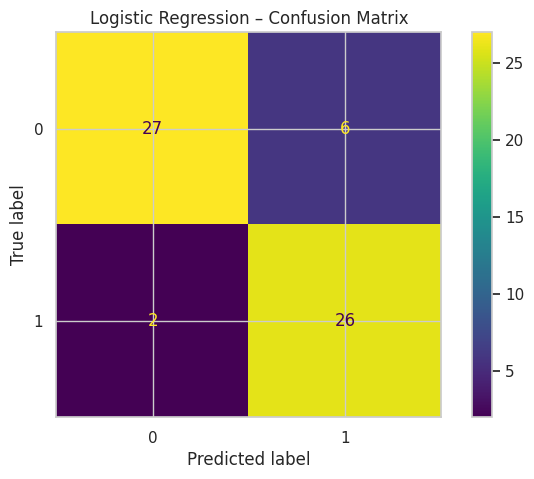

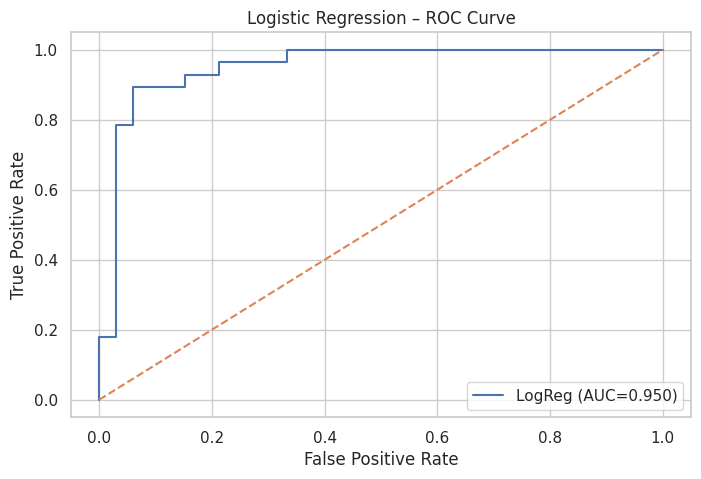

In [ ]:
# 4. BASELINE MODEL 1 – LOGISTIC REGRESSION

log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

log_reg.fit(X_train_scaled, y_train)

y_pred_log = log_reg.predict(X_test_scaled)
y_proba_log = log_reg.predict_proba(X_test_scaled)[:, 1]

log_acc = accuracy_score(y_test, y_pred_log)
log_prec = precision_score(y_test, y_pred_log, zero_division=0)
log_rec = recall_score(y_test, y_pred_log, zero_division=0)
log_f1 = f1_score(y_test, y_pred_log, zero_division=0)
log_auc = roc_auc_score(y_test, y_proba_log)

print("\n================ Logistic Regression (balanced) ================")
print("Accuracy :", round(log_acc, 3))
print("Precision:", round(log_prec, 3))
print("Recall   :", round(log_rec, 3))
print("F1-score :", round(log_f1, 3))
print("ROC-AUC  :", round(log_auc, 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_log, zero_division=0))

cm_log = confusion_matrix(y_test, y_pred_log)
ConfusionMatrixDisplay(cm_log).plot()
plt.title("Logistic Regression – Confusion Matrix")
plt.show()

fpr_log, tpr_log, thr_log = roc_curve(y_test, y_proba_log)
plt.figure()
plt.plot(fpr_log, tpr_log, label=f"LogReg (AUC={log_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression – ROC Curve")
plt.legend()
plt.show()


================ Random Forest (baseline) ================
Accuracy : 0.918
Precision: 0.871
Recall   : 0.964
F1-score : 0.915
ROC-AUC  : 0.958

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92        33
           1       0.87      0.96      0.92        28

    accuracy                           0.92        61
   macro avg       0.92      0.92      0.92        61
weighted avg       0.92      0.92      0.92        61



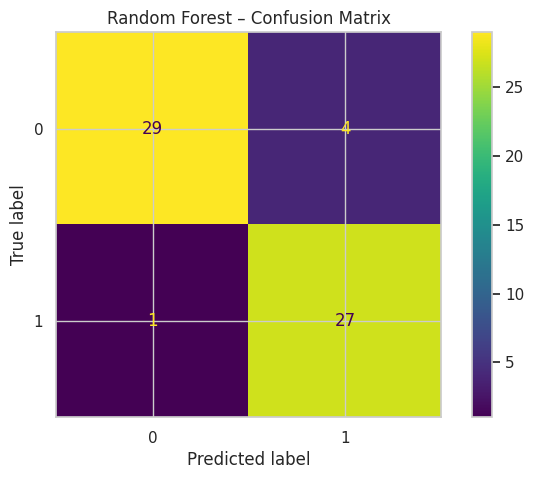

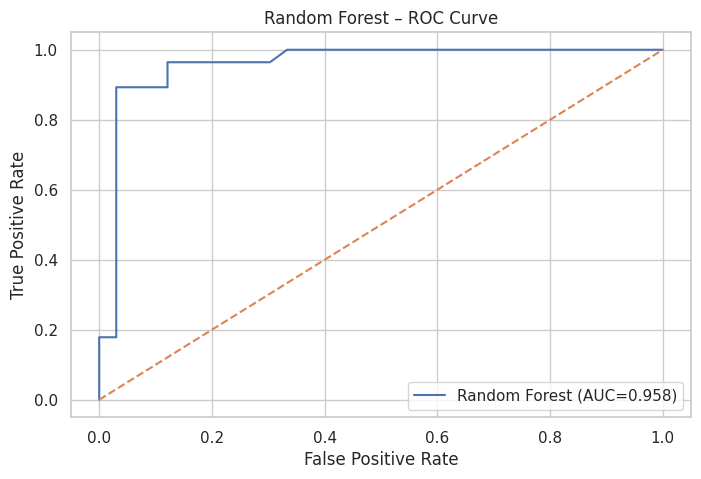

In [ ]:
# 5. BASELINE MODEL 2 – RANDOM FOREST

rf_clf = RandomForestClassifier(
    n_estimators=300,
    random_state=RANDOM_STATE,
    class_weight="balanced",
    n_jobs=-1
)

rf_clf.fit(X_train, y_train)   # trees don't need scaling

y_pred_rf = rf_clf.predict(X_test)
y_proba_rf = rf_clf.predict_proba(X_test)[:, 1]

rf_acc = accuracy_score(y_test, y_pred_rf)
rf_prec = precision_score(y_test, y_pred_rf, zero_division=0)
rf_rec = recall_score(y_test, y_pred_rf, zero_division=0)
rf_f1 = f1_score(y_test, y_pred_rf, zero_division=0)
rf_auc = roc_auc_score(y_test, y_proba_rf)

print("\n================ Random Forest (baseline) ================")
print("Accuracy :", round(rf_acc, 3))
print("Precision:", round(rf_prec, 3))
print("Recall   :", round(rf_rec, 3))
print("F1-score :", round(rf_f1, 3))
print("ROC-AUC  :", round(rf_auc, 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))

cm_rf = confusion_matrix(y_test, y_pred_rf)
ConfusionMatrixDisplay(cm_rf).plot()
plt.title("Random Forest – Confusion Matrix")
plt.show()

fpr_rf, tpr_rf, thr_rf = roc_curve(y_test, y_proba_rf)
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC={rf_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest – ROC Curve")
plt.legend()
plt.show()

In [ ]:
#Sprint 3
from xgboost import XGBClassifier

# Class imbalance weight: negatives / positives
pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    n_jobs=-1,

    # sensible starting point
    n_estimators=400,
    max_depth=3,
    learning_rate=0.05,

    subsample=0.9,
    colsample_bytree=0.9,

    min_child_weight=2,
    gamma=0.1,
    reg_lambda=2.0,

    scale_pos_weight=pos_weight  # make it care more about positive (sick) class
)

xgb_base.fit(X_train_scaled, y_train)
y_proba_xgb = xgb_base.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators":    [300, 400, 500],
    "max_depth":       [3, 4],
    "learning_rate":   [0.01, 0.05, 0.10],
    "subsample":       [0.8, 0.9, 1.0],
    "colsample_bytree":[0.8, 0.9, 1.0],
    "min_child_weight":[1, 2, 4],
    "gamma":           [0, 0.1, 0.3],
    "reg_lambda":      [1.0, 2.0, 4.0],
}

xgb_for_search = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    use_label_encoder=False,
    n_jobs=-1,
    scale_pos_weight=pos_weight
)

xgb_rand = RandomizedSearchCV(
    estimator=xgb_for_search,
    param_distributions=param_dist,
    n_iter=25,          # small but decent
    scoring="recall",   # or "f1" / "fbeta"
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

xgb_rand.fit(X_train_scaled, y_train)

print("\nBest params:", xgb_rand.best_params_)

best_xgb = xgb_rand.best_estimator_
y_proba_xgb = best_xgb.predict_proba(X_test_scaled)[:, 1]
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)

from sklearn.metrics import fbeta_score

xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_prec = precision_score(y_test, y_pred_xgb, zero_division=0)
xgb_rec = recall_score(y_test, y_pred_xgb, zero_division=0)
xgb_f1 = f1_score(y_test, y_pred_xgb, zero_division=0)
xgb_f2 = fbeta_score(y_test, y_pred_xgb, beta=2, zero_division=0)
xgb_auc = roc_auc_score(y_test, y_proba_xgb)

print("XGB – Accuracy:", xgb_acc)
print("XGB – Recall  :", xgb_rec)
print("XGB – F2      :", xgb_f2)


Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best params: {'subsample': 0.8, 'reg_lambda': 4.0, 'n_estimators': 400, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 1.0}
XGB – Accuracy: 0.8852459016393442
XGB – Recall  : 0.9285714285714286
XGB – F2      : 0.9090909090909091



Model Comparison:


,model_name,accuracy,precision,recall,f1,roc_auc
0,LogReg,0.868852,0.812500,0.928571,0.866667,0.950216
1,RandomForest,0.918033,0.870968,0.964286,0.915254,0.958333
2,XGBoost,0.885246,0.838710,0.928571,0.881356,0.944805


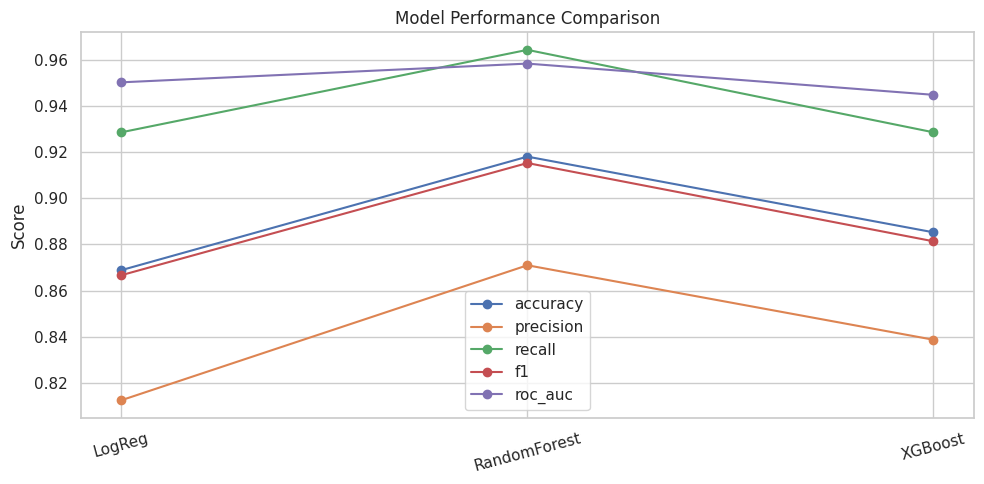

In [ ]:
# 7. MODEL COMPARISON

results_df = pd.DataFrame({
    "model_name": ["LogReg", "RandomForest", "XGBoost"],
    "accuracy":   [log_acc, rf_acc, xgb_acc],
    "precision":  [log_prec, rf_prec, xgb_prec],
    "recall":     [log_rec, rf_rec, xgb_rec],
    "f1":         [log_f1, rf_f1, xgb_f1],
    "roc_auc":    [log_auc, rf_auc, xgb_auc]
})

print("\nModel Comparison:")
display(results_df)

plt.figure(figsize=(10, 5))
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
for metric in metrics:
    plt.plot(results_df["model_name"], results_df[metric], marker="o", label=metric)

plt.xticks(rotation=15)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()


Initializing SHAP...



SHAP Summary Plot – Global Feature Importance


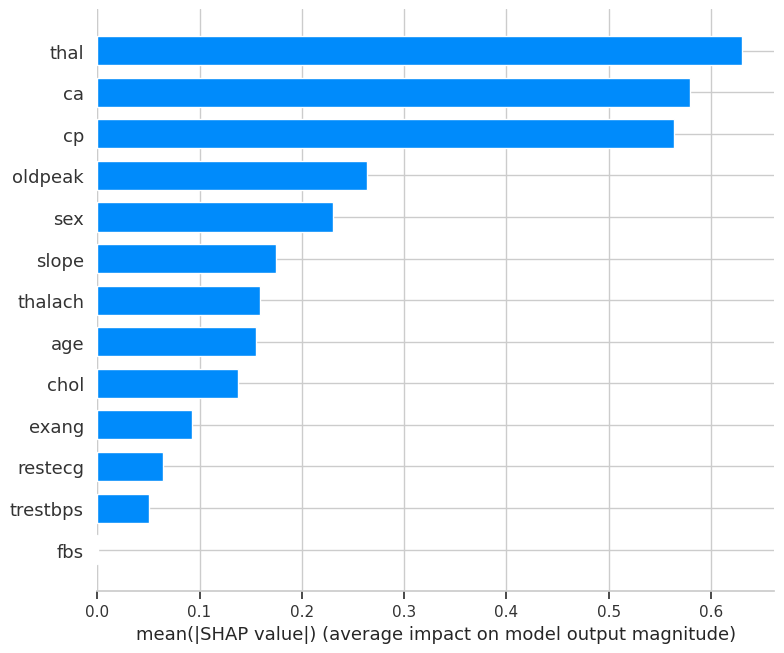


SHAP Summary Plot – Feature impact


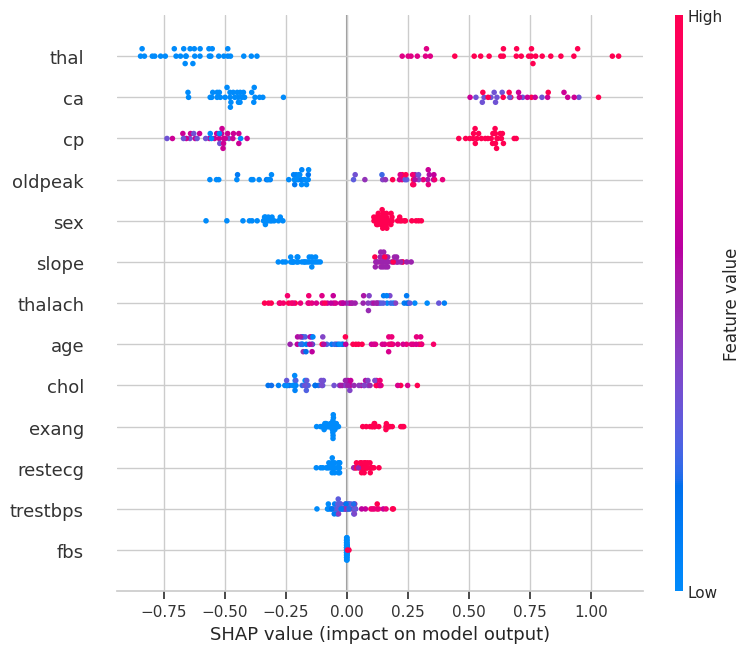


SHAP force plot for test sample index 1


In [ ]:
# 8. SHAP EXPLAINABILITY (FOR XGBOOST)

print("\nInitializing SHAP...")
shap.initjs()

explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_test_scaled)

print("\nSHAP Summary Plot – Global Feature Importance")
shap.summary_plot(shap_values, X_test, plot_type="bar")

print("\nSHAP Summary Plot – Feature impact")
shap.summary_plot(shap_values, X_test)

sample_index = 1
sample = X_test_scaled[sample_index:sample_index+1]
shap_values_sample = explainer.shap_values(sample)

print(f"\nSHAP force plot for test sample index {sample_index}")
shap.force_plot(explainer.expected_value, shap_values_sample, X_test.iloc[sample_index:sample_index+1])